## Homework 4 - Getting to know your customers

## 1.1) Set up the data
To start working download the banking dataset on Kaggle.

For the sake of this first part, not all columns are necessary since comparing each field single handedly can be quite time-expensive. Then, carefully read the linked guide above and try to understand which features will be appropriate for this task (An heads up: some users have more than one transaction record, make sure to handle them all). Once you have finished, project a version of the dataset to work with.

In [1]:
## import
#ao frate commento jrbguiaj
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

In [5]:
bt=pd.read_csv("C:/Users/Gabbo/Desktop/HW4/bank_transactions.csv")

### missing values

In [6]:
bt.dropna(inplace=True)

### convert to timedate

In [8]:
bt.CustomerDOB = pd.to_datetime(bt.CustomerDOB)
bt.TransactionDate = pd.to_datetime(bt.TransactionDate)

In [9]:
def zeros(x):
    l = len(x)
    if l != 6:
        x = '0' * (6-l) + x
    return x

In [11]:
bt.TransactionTime = list(map(str,bt.TransactionTime))
bt.TransactionTime = list(map(zeros,bt.TransactionTime))
bt.TransactionTime = bt.TransactionTime.apply(lambda x: f'{x[:2]}:{x[2:4]}:{x[4:]}')
bt.TransactionTime = pd.to_datetime(bt.TransactionTime, format='%H:%M:%S')

<AxesSubplot:>

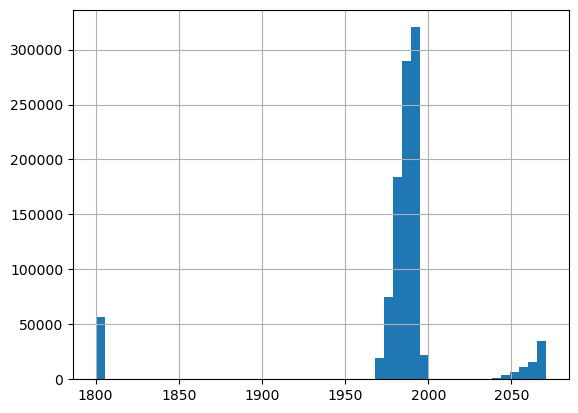

In [13]:
bt.CustomerDOB.dt.year.hist(bins=50)

In [14]:
bt.loc[bt.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = bt.loc[bt.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
bt.drop(bt[bt.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

<AxesSubplot:>

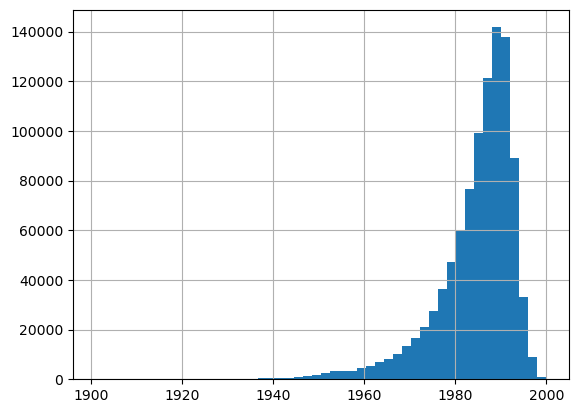

In [16]:
bt.CustomerDOB.dt.year.hist(bins=50)

### customer age
calculating customer age

In [17]:
bt['CustomerAge'] = (( pd.to_datetime('today') - bt.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
bt['CustomerAge'] = bt['CustomerAge'].astype(int)

In [18]:
bt['TransactionAmount (INR)'] = bt['TransactionAmount (INR)'].astype(int)
bt['Utilisation'] = bt['CustAccountBalance'] - bt['TransactionAmount (INR)']

In [19]:
bt.to_pickle("C:/Users/Gabbo/Desktop/HW4/bank.pkl")   #save as pickle

In [2]:
#to load
bt = pd.read_pickle("C:/Users/Gabbo/Desktop/HW4/bank.pkl")

CustomersID are not unique so we take only last row of same CustomerID and take age and CustAccountBalance

In [22]:
bt.groupby('CustomerID').CustomerAge.last()

CustomerID
C1010011    40
C1010012    28
C1010014    38
C1010018    32
C1010024    57
            ..
C9099836    32
C9099877    26
C9099919    29
C9099941    28
C9099956    40
Name: CustomerAge, Length: 839081, dtype: int32

In [23]:
age_balance = bt[['CustomerID', 'CustomerAge', 'CustAccountBalance']].groupby('CustomerID').last()

## 1.2) Fingerprint hashing
Using the previously selected data with the features you found pertinent, you have to:

Implement your minhash function from scratch. No ready-made hash functions are allowed. Read the class material and search the internet if you need to. For reference, it may be practical to look at the description of hash functions in the book.

Process the dataset and add each record to the MinHash. The subtask's goal is to try and map each consumer to its bin; to ensure this works well, be sure you understand how MinHash works and choose a matching threshold to use. Before moving on, experiment with different thresholds, explaining your choice.

## 1.3) Locality Sensitive Hashing
Now that you prepared your algorithm, it's query time!
We have prepared some dummy users for you to work with.

Download this csv and report the most similar users (comparing them against the dataset provided in Kaggle).
Did your hashing method work properly, what scores have you obtained and how long did it take to run? Provide information and analysis about the results.

## 2.1) Getting your data + feature engineering
Access to the data found in this dataset (it is the same dataset from the previous question 1.1).

Sometimes, the features (variables, fields) are not given in a dataset but can be created from it. The previous step is known as feature engineering. For example, the original dataset has several transactions done by the same customer. Then, we ask you to group data by the client (using CustomerId) and, based on it, create the following new features for each CustomerId:

a) Number of transactions

b) Number of transactions with a balance bigger than 100 USD

c) Average amount of the transactions

d) Average balance

e) Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).

f) Gender of the customer

h) Most frequent location of the customer
So, in the end, you should have for each CustomerID seven features.

Consider at least 20 additional features that can be generated for each CustomerId. Describe each of them and why you believe they will be helpful. Moreover, add it to the previous dataset (the one with seven features). In the end, you should have for each CustomerID at least 27 features (7 recommended + 20 suggested by you).

Hints for feature engineering:

- Instead of only using the average, you could use other functions such as minimum, maximum, percentiles, etc.
- Think of adding filters to your features. For instance, in "Number of transactions with balance bigger than 100 USD”, 
  the filter was "bigger than 100 USD". Can you think about other filters, even including other variables?
- Think of including the information given by the fields transaction date and time in your calculations.
- Think about getting information from a customer’s birthday, even comparing it to other fields.
- You could also calculate percentages in your features. Think of a plausible set of percentages worth to be calculated.

In [3]:
##num transazioni per cliente
numtran = bt[["TransactionID","CustomerID"]].groupby("CustomerID").count().sort_values(by="TransactionID",ascending=False)
numtran

,TransactionID
CustomerID,
C3226689,6
C6624352,6
C6222360,6
C1736254,6
C6735477,6
...,...
C3919813,1
C3919819,1
C3919827,1


In [4]:
#num transazioni con piu di 100 di balance
a = bt[["CustomerID","CustAccountBalance","TransactionID"]]
bal100 = a.groupby("CustomerID")["CustAccountBalance"].apply(lambda x: (x>100).sum()).reset_index(name='count')

In [26]:
bal100.sort_values(by="count",ascending=False)

,CustomerID,count
232163,C3226689,6
541202,C6222360,6
79256,C1736254,6
596683,C6735477,6
4342,C1026833,6
...,...,...
585667,C6633081,0
381560,C4648037,0
344325,C4320221,0
106619,C2022366,0


In [5]:
#merge dei primi due
x= numtran.merge(bal100,on="CustomerID")
x

,CustomerID,TransactionID,count
0,C3226689,6,6
1,C6624352,6,6
2,C6222360,6,6
3,C1736254,6,6
4,C6735477,6,6
...,...,...,...
839076,C3919813,1,1
839077,C3919819,1,1
839078,C3919827,1,1
839079,C3919828,1,1


In [6]:
#Average amount of the transactions
avgamount = bt[["CustomerID","TransactionID","TransactionAmount (INR)"]]
avgamount2 = avgamount.groupby("CustomerID").agg(Average_Amount=("TransactionAmount (INR)",np.mean))

In [7]:
#merge 12-3
x2 = avgamount2.merge(x,on="CustomerID")
x2

,CustomerID,Average_Amount,TransactionID,count
0,C1010011,2553.0,2,2
1,C1010012,1499.0,1,1
2,C1010014,727.5,2,2
3,C1010018,30.0,1,1
4,C1010024,5000.0,1,1
...,...,...,...,...
839076,C9099836,691.0,1,1
839077,C9099877,222.0,1,1
839078,C9099919,126.0,1,1
839079,C9099941,50.0,1,1


In [8]:
#average balance
avgbalance = bt[["CustomerID","TransactionID","CustAccountBalance"]]
avgbalance2 = avgbalance.groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.mean))

In [9]:
#merge 123-4
x3=avgbalance2.merge(x2,on="CustomerID")
x3

,CustomerID,Average_Balance,Average_Amount,TransactionID,count
0,C1010011,76340.635,2553.0,2,2
1,C1010012,24204.490,1499.0,1,1
2,C1010014,100112.950,727.5,2,2
3,C1010018,496.180,30.0,1,1
4,C1010024,87058.650,5000.0,1,1
...,...,...,...,...,...
839076,C9099836,133067.230,691.0,1,1
839077,C9099877,96063.460,222.0,1,1
839078,C9099919,5559.750,126.0,1,1
839079,C9099941,35295.920,50.0,1,1


In [10]:
# utilisation for each CID
utl = bt[["CustomerID","CustAccountBalance","TransactionAmount (INR)"]]
utl["Utilisation"] = utl["CustAccountBalance"]-utl["TransactionAmount (INR)"]
utl2=utl.groupby("CustomerID").agg(Utilisation=("Utilisation",np.mean))
utl2

,Utilisation
CustomerID,
C1010011,73787.635
C1010012,22705.490
C1010014,99385.450
C1010018,466.180
C1010024,82058.650
...,...
C9099836,132376.230
C9099877,95841.460
C9099919,5433.750


In [11]:
#merge 1234-5
x4=utl2.merge(x3,on="CustomerID")
x4

,CustomerID,Utilisation,Average_Balance,Average_Amount,TransactionID,count
0,C1010011,73787.635,76340.635,2553.0,2,2
1,C1010012,22705.490,24204.490,1499.0,1,1
2,C1010014,99385.450,100112.950,727.5,2,2
3,C1010018,466.180,496.180,30.0,1,1
4,C1010024,82058.650,87058.650,5000.0,1,1
...,...,...,...,...,...,...
839076,C9099836,132376.230,133067.230,691.0,1,1
839077,C9099877,95841.460,96063.460,222.0,1,1
839078,C9099919,5433.750,5559.750,126.0,1,1
839079,C9099941,35245.920,35295.920,50.0,1,1


In [17]:
#Gender of the customer
gender=bt[["CustomerID","CustGender"]].groupby("CustomerID").last()
gender

,CustGender
CustomerID,
C1010011,M
C1010012,M
C1010014,M
C1010018,F
C1010024,M
...,...
C9099836,M
C9099877,M
C9099919,M


In [19]:
#merge 12345-6
x5=gender.merge(x4,on="CustomerID")
x5

,CustomerID,CustGender,Utilisation,Average_Balance,Average_Amount,TransactionID,count
0,C1010011,M,73787.635,76340.635,2553.0,2,2
1,C1010012,M,22705.490,24204.490,1499.0,1,1
2,C1010014,M,99385.450,100112.950,727.5,2,2
3,C1010018,F,466.180,496.180,30.0,1,1
4,C1010024,M,82058.650,87058.650,5000.0,1,1
...,...,...,...,...,...,...,...
839076,C9099836,M,132376.230,133067.230,691.0,1,1
839077,C9099877,M,95841.460,96063.460,222.0,1,1
839078,C9099919,M,5433.750,5559.750,126.0,1,1
839079,C9099941,M,35245.920,35295.920,50.0,1,1


In [20]:
#Most frequent location of the customer
loc = bt[["CustomerID","CustLocation"]].groupby("CustomerID").agg(pd.Series.mode)
loc

,CustLocation
CustomerID,
C1010011,"[NEW DELHI, NOIDA]"
C1010012,MUMBAI
C1010014,MUMBAI
C1010018,CHAMPARAN
C1010024,KOLKATA
...,...
C9099836,BHIWANDI
C9099877,BANGALORE
C9099919,GUNTUR


In [23]:
#merge 123456-7:
x6=loc.merge(x5,on="CustomerID")
x6

,CustomerID,CustLocation,CustGender,Utilisation,Average_Balance,Average_Amount,TransactionID,count
0,C1010011,"[NEW DELHI, NOIDA]",M,73787.635,76340.635,2553.0,2,2
1,C1010012,MUMBAI,M,22705.490,24204.490,1499.0,1,1
2,C1010014,MUMBAI,M,99385.450,100112.950,727.5,2,2
3,C1010018,CHAMPARAN,F,466.180,496.180,30.0,1,1
4,C1010024,KOLKATA,M,82058.650,87058.650,5000.0,1,1
...,...,...,...,...,...,...,...,...
839076,C9099836,BHIWANDI,M,132376.230,133067.230,691.0,1,1
839077,C9099877,BANGALORE,M,95841.460,96063.460,222.0,1,1
839078,C9099919,GUNTUR,M,5433.750,5559.750,126.0,1,1
839079,C9099941,CHENNAI,M,35245.920,35295.920,50.0,1,1


In [25]:
x6.to_pickle("C:/Users/Gabbo/Desktop/HW4/bank2.pkl")   #save as pickle

In [27]:
#load new pickle:
bt2 = pd.read_pickle("C:/Users/Gabbo/Desktop/HW4/bank2.pkl")
bt2

,CustomerID,CustLocation,CustGender,Utilisation,Average_Balance,Average_Amount,TransactionID,count
0,C1010011,"[NEW DELHI, NOIDA]",M,73787.635,76340.635,2553.0,2,2
1,C1010012,MUMBAI,M,22705.490,24204.490,1499.0,1,1
2,C1010014,MUMBAI,M,99385.450,100112.950,727.5,2,2
3,C1010018,CHAMPARAN,F,466.180,496.180,30.0,1,1
4,C1010024,KOLKATA,M,82058.650,87058.650,5000.0,1,1
...,...,...,...,...,...,...,...,...
839076,C9099836,BHIWANDI,M,132376.230,133067.230,691.0,1,1
839077,C9099877,BANGALORE,M,95841.460,96063.460,222.0,1,1
839078,C9099919,GUNTUR,M,5433.750,5559.750,126.0,1,1
839079,C9099941,CHENNAI,M,35245.920,35295.920,50.0,1,1


## 2.2) Choose your features (variables)!
As you may notice, you have plenty of features to work with now. So, you need to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

To normalise or not to normalise? That's the question. Sometimes it is worth normalising (scaling) the features. Explain if it is a good idea to perform any normalisation method. If you think the normalisation should be used, apply it to your data (look at the available normalisation functions in the scikit-learn library).

Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

Apply the selected method(s) to your data. Ensure the chosen method retains > 70% of the total variance.

## 2.3) Clustering!
Implement the K-means clustering algorithm (not ++: random initialization). We ask you to write the algorithm from scratch following what you learned in class. !! We also ask you to use MapReduce in your K-means algorithm.

Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

Run the algorithm on the data.

Then, use the already implemented version of K-means++ (from the scikit-learn library). Explain the differences (if there are any) in the results.

## 2.4) Analysing your results!
You are often encouraged to explain the main characteristics that your clusters have. This is called the Characterizing Clusters step. Thus, follow the next steps to do it:

Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, CustGender, Number of transactions, etc.

Most of your selected variables will be numerical (continuous or discrete), then categorise them into four categories.

With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100. The sample example for clustering with K = 4 and Gender variable:

Interpret the results for each pivot table.

Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?).

